In [1]:
import osmnx as ox
import geopandas as gpd

# center coordinate (lat, lon)
lat = 36.1627
lon = -86.7816

# radius in meters
radius = 1500

# OSM tags we want
tags = {
    "amenity": "parking"
}

# Query OSM
gdf = ox.features_from_point((lat, lon), tags=tags, dist=radius)

print(gdf.head())
print("Total parking features:", len(gdf))

                                                              geometry  \
element  id                                                              
node     1440957148                         POINT (-86.77752 36.16732)   
relation 6410905     POLYGON ((-86.7672 36.15748, -86.76717 36.1575...   
         6858127     POLYGON ((-86.77958 36.16676, -86.77936 36.166...   
         6927234     POLYGON ((-86.77343 36.16824, -86.77309 36.167...   
way      43068539    POLYGON ((-86.78876 36.15115, -86.78906 36.151...   

                     amenity layer                                 name  \
element  id                                                               
node     1440957148  parking    -1  Public Square Parking (underground)   
relation 6410905     parking   NaN                                  NaN   
         6858127     parking   NaN                 Public Square Garage   
         6927234     parking   NaN                                Lot M   
way      43068539    parking   

In [2]:
garages = gdf[gdf["parking"] == "multi-storey"]
surface = gdf[gdf["parking"] == "surface"]

print("Garages:", len(garages))
print("Surface lots:", len(surface))

Garages: 37
Surface lots: 125


NameError: name 'plt' is not defined

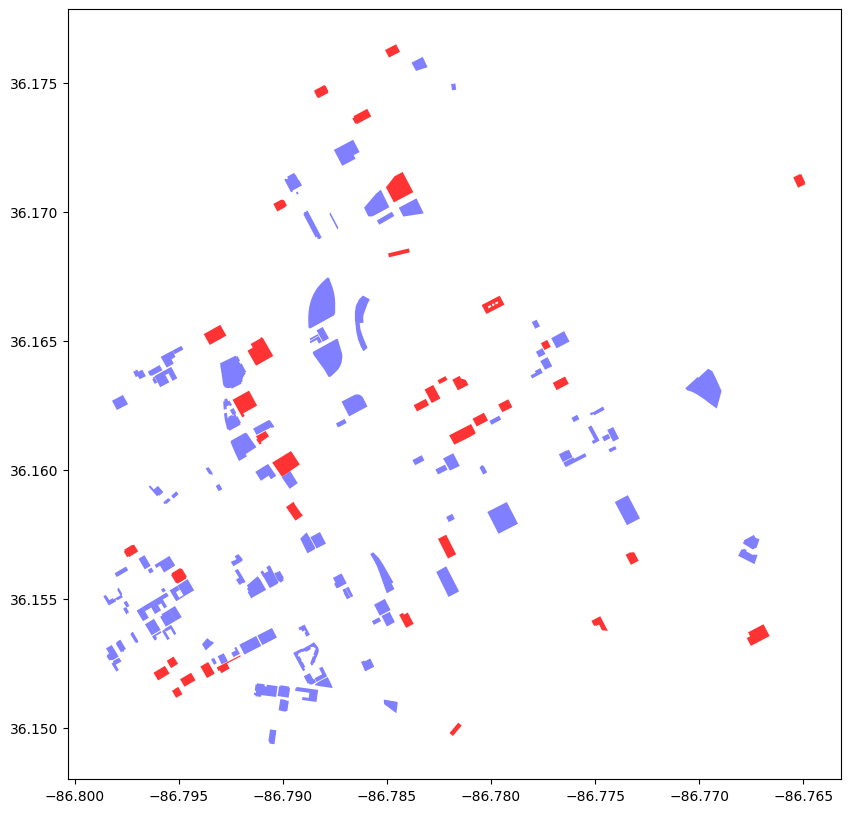

In [3]:
ax = surface.plot(color="blue", alpha=0.5, figsize=(10,10))
garages.plot(ax=ax, color="red", alpha=0.8)

plt.show()

In [4]:
building_tags = {"building": True}

buildings = ox.features_from_point(
    (lat, lon),
    tags=building_tags,
    dist=radius
)

print("Buildings:", len(buildings))

Buildings: 2286


In [11]:
from pathlib import Path
from itertools import product
from urllib.request import urlopen
import tarfile
from typing import Union, Sequence, Optional, List
from io import BytesIO, TextIOWrapper
import csv

import pandas as pd # If use in_memory = True & use_pandas = True


def load_nba_data(path: Union[Path, str] = Path.cwd(),
                  seasons: Union[Sequence, int] = range(1996, 2024),
                  data: Union[Sequence, str] = ("datanba", "nbastats", "pbpstats",
                                                "shotdetail", "cdnnba", "nbastatsv3",
                                                "matchups"),
                  seasontype: str = 'rg',
                  league: str = 'nba',
                  untar: bool = False,
                  in_memory: bool = False,
                  use_pandas: bool = True) -> Optional[Union[List, pd.DataFrame]]:
    """
    Loading a nba play-by-play dataset from github repository https://github.com/shufinskiy/nba_data

    Args:
        path (Union[Path, str]): Path where downloaded file should be saved on the hard disk. Not used if in_memory = True
        seasons (Union[Sequence, int]): Sequence or integer of the year of start of season
        data (Union[Sequence, str]): Sequence or string of data types to load
        seasontype (str): Part of season: rg - Regular Season, po - Playoffs
        league (str): Name league: NBA or WNBA
        untar (bool): Logical: do need to untar loaded archive. Not used if in_memory = True
        in_memory (bool): Logical: If True dataset is loaded into workflow, without saving file to disk
        use_pandas (bool): Logical: If True dataset is loaded how pd.DataFrame, else List[List[str]]. Ignore if in_memory=False

    Returns:
        Optional[pd.DataFrame, List]: If in_memory=True and use_pandas=True return dataset how pd.DataFrame.
        If use_pandas=False return dataset how List[List[str]]
        If in_memory=False return None
    """
    if isinstance(path, str):
        path = Path(path).expanduser()
    if isinstance(seasons, int):
        seasons = (seasons,)
    if isinstance(data, str):
        data = (data,)

    if (len(data) > 1) & in_memory:
        raise ValueError("Parameter in_memory=True available only when loading a single data type")

    if seasontype == 'rg':
        need_data = tuple(["_".join([data, str(season)]) for (data, season) in product(data, seasons)])
    elif seasontype == 'po':
        need_data = tuple(["_".join([data, seasontype, str(season)]) \
                           for (data, seasontype, season) in product(data, (seasontype,), seasons)])
    else:
        need_data_rg = tuple(["_".join([data, str(season)]) for (data, season) in product(data, seasons)])
        need_data_po = tuple(["_".join([data, seasontype, str(season)]) \
                              for (data, seasontype, season) in product(data, ('po',), seasons)])
        need_data = need_data_rg + need_data_po
    if league.lower() == 'wnba':
        need_data = ['wnba_' + x for x in need_data]

    check_data = [file + ".csv" if untar else file + ".tar.xz" for file in need_data]
    not_exists = [not path.joinpath(check_file).is_file() for check_file in check_data]

    need_data = [file for (file, not_exist) in zip(need_data, not_exists) if not_exist]

    with urlopen("https://raw.githubusercontent.com/shufinskiy/nba_data/main/list_data.txt") as f:
        v = f.read().decode('utf-8').strip()

    name_v = [string.split("=")[0] for string in v.split("\n")]
    element_v = [string.split("=")[1] for string in v.split("\n")]

    need_name = [name for name in name_v if name in need_data]
    need_element = [element for (name, element) in zip(name_v, element_v) if name in need_data]

    if in_memory:
        if use_pandas:
            table = pd.DataFrame()
        else:
            table = []
    for i in range(len(need_name)):
        with urlopen(need_element[i]) as response:
            if response.status != 200:
                raise Exception(f"Failed to download file: {response.status}")
            file_content = response.read()
            if in_memory:
                with tarfile.open(fileobj=BytesIO(file_content), mode='r:xz') as tar:
                    csv_file_name = "".join([need_name[i], ".csv"])
                    csv_file = tar.extractfile(csv_file_name)
                    if use_pandas:
                        table = pd.concat([table, pd.read_csv(csv_file)], axis=0, ignore_index=True)
                    else:
                        csv_reader = csv.reader(TextIOWrapper(csv_file, encoding="utf-8"))
                        for row in csv_reader:
                            table.append(row)
            else:
                with path.joinpath("".join([need_name[i], ".tar.xz"])).open(mode='wb') as f:
                    f.write(file_content)
                if untar:
                    with tarfile.open(path.joinpath("".join([need_name[i], ".tar.xz"]))) as f:
                        f.extract("".join([need_name[i], ".csv"]), path)

                    path.joinpath("".join([need_name[i], ".tar.xz"])).unlink()
    if in_memory:
        return table
    else:
        return None

In [19]:
from pathlib import Path

NEEDED = ("nbastats", "matchups", "shotdetail")

def download_needed(
    out_dir: str | Path,
    seasons=range(1996, 2001),
    untar: bool = False,   # False = save .tar.xz, True = extract .csv and delete archive (per your function)
    league: str = "nba",
):
    out_dir = Path(out_dir).expanduser()
    out_dir.mkdir(parents=True, exist_ok=True)

    # Regular season -> nbastats, matchups, shotdetail
    load_nba_data(
        path=out_dir,
        seasons=seasons,
        data=NEEDED,
        seasontype="rg",
        league=league,
        untar=untar,
        in_memory=False,
    )

    # Playoffs -> nbastats_po, matchups_po, shotdetail_po
    load_nba_data(
        path=out_dir,
        seasons=seasons,
        data=NEEDED,
        seasontype="po",
        league=league,
        untar=untar,
        in_memory=False,
    )

# Example:
download_needed(r"C:\nba_data\datasets", seasons=range(1996, 2001), untar=True)

08-12 
96-2000